In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from AnchorOptimalProjector import *
from MVA_algo import ReducedRankRegressor, OPLS, OPLS2
import scipy
import h5py

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [23]:
N=1500
coarse=6
var = 'psl'
directory = '../weights/'
if var == 'pr':
    file = 'Anchor_OPLS_{}_weights_stability_n{}_coarse{}.pkl'.format('precip', N, coarse)
elif var == 'tas' :
    file = 'Anchor_OPLS_{}_weights_stability_n{}_coarse{}.pkl'.format(var, 600, coarse)
else :
    file = 'Anchor_OPLS_{}_weights_stability_n{}_coarse{}.pkl'.format(var, N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [24]:
gamma = 5
total_weights = np.zeros(weights['CanESM5'][gamma]['weights'].shape)
total_samples = 0
for model in models:
    total_weights += weights[model][gamma]['weights']*weights[model][gamma]['n_samples']
    total_samples += weights[model][gamma]['n_samples']
total_weights /= total_samples

In [25]:
path='../data/Evaluation-Tier1/Amon/{}'.format(var)
path2='../predictions/{}'.format(var)

for file in os.listdir(path) :
    file_path = os.path.join(path, file)
    print(file_path)
    ds = xr.open_dataset(file_path)
    # Compute anomalies
    climatology = ds.groupby('time.month').mean(dim='time')
    anomalies = ds.groupby('time.month') - climatology
    shape = anomalies[var].shape
    anomalies_regional = anomalies[var].values.reshape(shape[0], shape[1]//coarse, coarse, shape[2]//coarse, coarse)
    X = anomalies_regional.mean(axis=(2, 4)).reshape(shape[0], (shape[1]//coarse) * (shape[2]//coarse))
    
    Y_pred = X @ total_weights
    
    Y_pred_spatial = Y_pred.reshape(shape[0], shape[1], shape[2])
    
    
    
    ds[var][:] = Y_pred_spatial 
    #ds = ds.groupby('time.month') + climatology
    
    file_path2 = os.path.join(path2, file[:-3] + 'predictions.c')
    ds.to_netcdf(file_path2)
    
    ds.close()

../data/Evaluation-Tier1/Amon/psl/psl_mon_1A.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1E.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1I.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1C.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1J.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1F.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1D.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1G.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1H.195001-202212.nc
../data/Evaluation-Tier1/Amon/psl/psl_mon_1B.195001-202212.nc


## Checking predictions

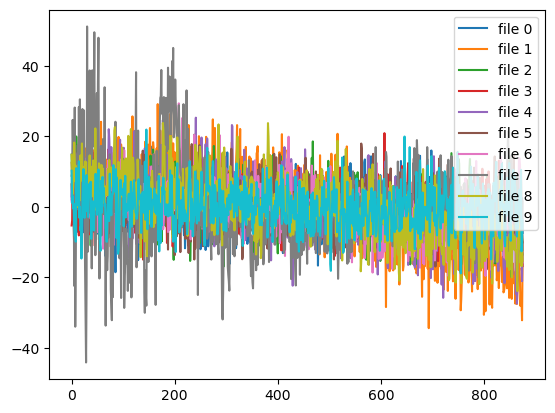

In [26]:
path2='../predictions/{}'.format(var)
i=0
for file in os.listdir(path2) :
    file_path = os.path.join(path2, file)
    ds = xr.open_dataset(file_path)
    plt.plot(ds[var].values.mean(axis=(1, 2)), label='file {}'.format(i))
    ds.close()
    i+=1
plt.legend()
plt.show()